<h1 style="text-align: center;">
    Numerical Methods : <br>
    Quantum dynamics and quantum control <br>
    Lattice spin systems
</h1>
<p style="text-align: center;">
Léo BECHET, M2 CompuPhys 2024-2025
</p>

The following is a report for the 2024-2025 M2 COmpuPhys DQC teaching unit.

# Provided base functions

In [1]:
import numpy as np
import scipy as sp
from numpy import linalg as la
import matplotlib.pyplot as plt
from numpy import linalg as LA;
from scipy import linalg as LA2;
from numpy import random as rand
from scipy.sparse import diags, csr_matrix


In [2]:
def tensorvect(a,b):
    return(np.tensordot(a,b,axes=0).flatten())

def tensorvectop(a,b):
    return LA2.kron(a,b)

def opchain(a,i,nspin):
    if i==1:
        return LA2.kron(a,np.identity(2**(nspin-1)))
    else:
        if i==nspin:
            return LA2.kron(np.identity(2**(nspin-1)),a)
        else:
            return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),np.identity(2**(nspin-i)))
        
def opchain2(a,i,b,j,nspin):
    if i==1:
        if j==nspin:
            return LA2.kron(LA2.kron(a,np.identity(2**(nspin-2))),b)
        else:
            return LA2.kron(LA2.kron(a,np.identity(2**(j-2))),LA2.kron(b,np.identity(2**(nspin-j))))      
    else:
        if j==nspin:
            return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(nspin-(i+1))),b))
        else:
            return LA2.kron(LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(j-(i+1))),b)),np.identity(2**(nspin-j)))
            
def buildstate(bin):
    v=[0. for i in range(2**len(bin))];
    v[int(bin,2)]=1.
    return np.array(v)


def diracrep(psi,nspin,rounding):
    state='';
    for i in range(2**nspin):
        if abs(psi[i])>10**(-6):
            # state=state+'+'+str(round(psi[i], rounding))+'|'+format(i,'0'+str(nspin)+'b')+'>' # original
            state = state + '\033[32m+\033[31m' + str(round(psi[i], rounding)) + '\033[34m|' + format(i, '0' + str(nspin) + 'b') + '>\033[0m'
    return state

def binnum(n):
    l=['0','1'];
    if n==1:
        return l
    else:
        return ['0'+i for i in binnum(n-1)]+['1'+i for i in binnum(n-1)]
    
def densmat(psi,i,nspin):
    if i>1:
        listindex0=binnum(i-1)
        listindex0=[j+'0' for j in listindex0]
    else:
        listindex0=['0']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex0=list(np.array([[j+k for k in listcomp] for j in listindex0]).flatten())
    if i>1:
        listindex1=binnum(i-1)
        listindex1=[j+'1' for j in listindex1]
    else:
        listindex1=['1']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex1=list(np.array([[j+k for k in listcomp] for j in listindex1]).flatten())
    rho00=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex0)
    rho11=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex1)
    rho01=sum(psi[int(j,2)]*np.conjugate(psi[int(listindex1[listindex0.index(j)],2)]) for j in listindex0)
    return np.array([[rho00,rho01],[np.conjugate(rho01),rho11]])

def avdensmat(psi,nspin):
    rho=densmat(psi,1,nspin);
    if nspin>1:
        for i in range(2,nspin+1):
            rho=rho+densmat(psi,i,nspin)
    rho=rho/nspin;
    return rho

def purity(rho):
    rho2 = np.dot(rho,rho)
    tr = np.trace(rho2)
    return(tr)

def SvN(rho):
    vp=np.real(LA.eigvals(rho));
    S=0.;
    for i in range(len(vp)):
        if vp[i]>0.:
            S=S+vp[i]*np.log(vp[i])
    return -S

def entangl(psi,nspin):
    S=SvN(densmat(psi,1,nspin));
    if nspin>1:
        for i in range(2,nspin+1):
            S=S+SvN(densmat(psi,i,nspin))
    return S/nspin

def Disorder(psi,nspin):
    return SvN(avdensmat(psi,nspin))-entangl(psi,nspin)

# Personal Work

## 2.1 - Studied models

In [3]:
class S:
    def __init__(self):
        self.x = 0.5 * np.array([[0, 1], [1, 0]])
        self.y = 0.5 * np.array([[0, -1j], [1j, 0]])
        self.z = 0.5 * np.array([[1, 0], [0, -1]])

S = S()


In [4]:
class J:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z


In [5]:
# Sigma matrices class
class Sigma:
    def __init__(self):
        self.x = 0.5 * np.array([[-1, 0],[0,0]])
        # Add the other
        
Sigma = Sigma()

### [1] Open Ising-Z spin chain

In [6]:
# Open spin chain Z
def Htot_1(n, J_z = 1, omega=1):
    
    # J_z = 1

    # Free hamiltonian
    H0 = np.zeros((2**n, 2**n))
    # I defined omega sigma...
    if omega==0:
        for i in range(1,n+1):
            Sigma_x = 0*np.array([[-1, 0],[0,0]])
            H0 += opchain(Sigma_x, i, n)

    else:        
        for i in range(1,n+1):
            H0 += opchain(Sigma.x, i, n)


    Hint = np.zeros((2**n, 2**n))
    for i in range(n-1):
        Hint += -J_z * opchain2(S.z, i+1, S.z, i+2, n)

    # print("H0: \n", H0)
    # print("Hint: \n", Hint)

    Htot = H0 + Hint
    return Htot


print(Htot_1(2))
print(Htot_1(3))
print(csr_matrix(Htot_1(8)))







[[-1.25  0.    0.    0.  ]
 [ 0.   -0.25  0.    0.  ]
 [ 0.    0.   -0.25  0.  ]
 [ 0.    0.    0.   -0.25]]
[[-2.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 256 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-5.75
  (1, 1)	-4.75
  (2, 2)	-4.25
  (3, 3)	-4.25
  (4, 4)	-4.25
  (5, 5)	-3.25
  (6, 6)	-3.75
  (7, 7)	-3.75
  (8, 8)	-4.25
  (9, 9)	-3.25
  (10, 10)	-2.75
  (11, 11)	-2.75
  (12, 12)	-3.75
  (13, 13)	-2.75
  (14, 14)	-3.25
  (15, 15)	-3.25
  (16, 16)	-4.25
  (17, 17)	-3.25
  (18, 18)	-2.75
  (19, 19)	-2.75
  (20, 20)	-2.75
  (21, 21)	-1.75
  (22, 22)	-2.25
  (23, 23)	-2.25
  (24, 24)	-3.75
  :	:
  (231, 231)	-1

### [2] Closed Ising-Z spin chain

In [7]:
# Close spin chain Z
def Htot_2(n, J_z=1, omega=1):
    
    # J_z = 1

    # Free hamiltonian
    H0 = np.zeros((2**n, 2**n))
    # I defined omega sigma...
    if omega==0:
        for i in range(1,n+1):
            Sigma_x = 0*np.array([[-1, 0],[0,0]])
            H0 += opchain(Sigma_x, i, n)

    else:        
        for i in range(1,n+1):
            H0 += opchain(Sigma.x, i, n)



    Hint = np.zeros((2**n, 2**n))
    for i in range(n-1):
        Hint += -J_z * opchain2(S.z, i+1, S.z, i+2, n)
    Hint += -J_z * opchain2(S.z, 1, S.z, n, n )

    # print("H0: \n", H0)
    # print("Hint: \n", Hint)

    Htot = H0 + Hint
    return Htot


print(Htot_2(2))
print(Htot_2(3))
print(csr_matrix(Htot_2(8)))







[[-1.5  0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5]]
[[-2.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.75  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.75  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.25  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.75  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.25  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.25  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.75]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 254 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-6.0
  (1, 1)	-4.5
  (2, 2)	-4.5
  (3, 3)	-4.0
  (4, 4)	-4.5
  (5, 5)	-3.0
  (6, 6)	-4.0
  (7, 7)	-3.5
  (8, 8)	-4.5
  (9, 9)	-3.0
  (10, 10)	-3.0
  (11, 11)	-2.5
  (12, 12)	-4.0
  (13, 13)	-2.5
  (14, 14)	-3.5
  (15, 15)	-3.0
  (16, 16)	-4.5
  (17, 17)	-3.0
  (18, 18)	-3.0
  (19, 19)	-2.5
  (20, 20)	-3.0
  (21, 21)	-1.5
  (22, 22)	-2.5
  (23, 23)	-2.0
  (24, 24)	-4.

### [3]  Open Ising-X spin chain

In [8]:
# Open spin chain X
def Htot_3(n):
    
    J_z = 1

    # Free hamiltonian
    H0 = np.zeros((2**n, 2**n))
    for i in range(1,n+1):
        H0 += opchain(Sigma.x, i, n)


    Hint = np.zeros((2**n, 2**n))
    for i in range(n-1):
        Hint += -J_z * opchain2(S.x, i+1, S.x, i+2, n)

    # print("H0: \n", H0)
    # print("Hint: \n", Hint)

    Htot = H0 + Hint
    return Htot


print(Htot_3(2))
print(Htot_3(3))
print(csr_matrix(Htot_3(8)))







[[-1.    0.    0.   -0.25]
 [ 0.   -0.5  -0.25  0.  ]
 [ 0.   -0.25 -0.5   0.  ]
 [-0.25  0.    0.    0.  ]]
[[-1.5   0.    0.   -0.25  0.    0.   -0.25  0.  ]
 [ 0.   -1.   -0.25  0.    0.    0.    0.   -0.25]
 [ 0.   -0.25 -1.    0.   -0.25  0.    0.    0.  ]
 [-0.25  0.    0.   -0.5   0.   -0.25  0.    0.  ]
 [ 0.    0.   -0.25  0.   -1.    0.    0.   -0.25]
 [ 0.    0.    0.   -0.25  0.   -0.5  -0.25  0.  ]
 [-0.25  0.    0.    0.    0.   -0.25 -0.5   0.  ]
 [ 0.   -0.25  0.    0.   -0.25  0.    0.    0.  ]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2047 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-4.0
  (0, 3)	-0.25
  (0, 6)	-0.25
  (0, 12)	-0.25
  (0, 24)	-0.25
  (0, 48)	-0.25
  (0, 96)	-0.25
  (0, 192)	-0.25
  (1, 1)	-3.5
  (1, 2)	-0.25
  (1, 7)	-0.25
  (1, 13)	-0.25
  (1, 25)	-0.25
  (1, 49)	-0.25
  (1, 97)	-0.25
  (1, 193)	-0.25
  (2, 1)	-0.25
  (2, 2)	-3.5
  (2, 4)	-0.25
  (2, 14)	-0.25
  (2, 26)	-0.25
  (2, 50)	-0.25
  (2, 98)	-0.25
  (

### [4] Open Heisenberg-XXX spin chain

In [9]:
def Htot_4(n):
    
    J_x = 1
    J_y = 1
    J_z = 1

    # Free Hamiltonian (same as before)
    H0 = np.zeros((2**n, 2**n))
    for i in range(1, n+1):
        H0 += opchain(Sigma.x, i, n)

    Hint = np.zeros((2**n, 2**n))
    for i in range(n-1):
        # Add interactions for X, Y, and Z directions and cast to real if necessary
        Hint += np.real(-J_x * opchain2(S.x, i+1, S.x, i+2, n))
        Hint += np.real(-J_y * opchain2(S.y, i+1, S.y, i+2, n))
        Hint += np.real(-J_z * opchain2(S.z, i+1, S.z, i+2, n))

    Htot = H0 + Hint
    return Htot


print(Htot_4(2))
print(Htot_4(3))
print(csr_matrix(Htot_4(8)))


[[-1.25  0.    0.    0.  ]
 [ 0.   -0.25 -0.5   0.  ]
 [ 0.   -0.5  -0.25  0.  ]
 [ 0.    0.    0.   -0.25]]
[[-2.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.  -0.5  0.   0.   0.   0.   0. ]
 [ 0.  -0.5 -0.5  0.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.  -0.5  0.   0. ]
 [ 0.   0.  -0.5  0.  -1.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.  -0.5  0. ]
 [ 0.   0.   0.   0.   0.  -0.5 -0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1152 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-5.75
  (1, 1)	-4.75
  (1, 2)	-0.5
  (2, 1)	-0.5
  (2, 2)	-4.25
  (2, 4)	-0.5
  (3, 3)	-4.25
  (3, 5)	-0.5
  (4, 2)	-0.5
  (4, 4)	-4.25
  (4, 8)	-0.5
  (5, 3)	-0.5
  (5, 5)	-3.25
  (5, 6)	-0.5
  (5, 9)	-0.5
  (6, 5)	-0.5
  (6, 6)	-3.75
  (6, 10)	-0.5
  (7, 7)	-3.75
  (7, 11)	-0.5
  (8, 4)	-0.5
  (8, 8)	-4.25
  (8, 16)	-0.5
  (9, 5)	-0.5
  (9, 9)	-3.25
  :	:
  (246, 246)	-1.25
  (246, 250)	-0.5
  (247, 239)	-0.5
 

### [5] Heisenberg-XYZ open spin chain

In [10]:

def Htot_5(n):
    w = 1 # <= because factor 0.5 inside Sigma
    J = [0.5, 1.0, 1.5]
    
    # Free Hamiltonian H0 with fixed wi
    H0 = np.zeros((2**n, 2**n))
    for i in range(n):
        H0 += w * opchain(Sigma.x, i+1, n)

    # Interaction Hamiltonian Hint along Sx, Sy, and Sz
    Hint = np.zeros((2**n, 2**n))
    for i in range(n-1):
        Hint += np.real(-J[0] * opchain2(S.x, i+1, S.x, i+2, n))
        Hint += np.real(-J[1] * opchain2(S.y, i+1, S.y, i+2, n))
        Hint += np.real(-J[2] * opchain2(S.z, i+1, S.z, i+2, n))

    Htot = H0 + Hint
    return Htot

# print(Htot_5(2))
print(csr_matrix(Htot_5(8)))


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2048 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-6.625
  (0, 3)	0.125
  (0, 6)	0.125
  (0, 12)	0.125
  (0, 24)	0.125
  (0, 48)	0.125
  (0, 96)	0.125
  (0, 192)	0.125
  (1, 1)	-5.375
  (1, 2)	-0.375
  (1, 7)	0.125
  (1, 13)	0.125
  (1, 25)	0.125
  (1, 49)	0.125
  (1, 97)	0.125
  (1, 193)	0.125
  (2, 1)	-0.375
  (2, 2)	-4.625
  (2, 4)	-0.375
  (2, 14)	0.125
  (2, 26)	0.125
  (2, 50)	0.125
  (2, 98)	0.125
  (2, 194)	0.125
  (3, 0)	0.125
  :	:
  (252, 255)	0.125
  (253, 61)	0.125
  (253, 157)	0.125
  (253, 205)	0.125
  (253, 229)	0.125
  (253, 241)	0.125
  (253, 251)	-0.375
  (253, 253)	-1.625
  (253, 254)	-0.375
  (254, 62)	0.125
  (254, 158)	0.125
  (254, 206)	0.125
  (254, 230)	0.125
  (254, 242)	0.125
  (254, 248)	0.125
  (254, 253)	-0.375
  (254, 254)	-2.375
  (255, 63)	0.125
  (255, 159)	0.125
  (255, 207)	0.125
  (255, 231)	0.125
  (255, 243)	0.125
  (255, 249)	0.125
  (255, 252)	0.125
  (255, 255)	-2.

### [6] Random open Ising-X chain


In [11]:
def Htot_6(n):
    # Generate random Larmor frequencies wi in [0.0, 0.5]
    wi = np.random.uniform(0.0, 0.5, n)
    
    # Generate random exchange integrals Ji,i+1 in [-1.0, 1.0]
    Ji = np.random.uniform(-1.0, 1.0, n-1)
    
    # Free Hamiltonian H0 with random wi
    H0 = np.zeros((2**n, 2**n))
    for i in range(n):
        H0 += wi[i] * opchain(Sigma.x, i+1, n)

    # Interaction Hamiltonian Hint with random Ji
    Hint = np.zeros((2**n, 2**n))
    for i in range(n-1):
        Hint += np.real(-Ji[i] * opchain2(S.x, i+1, S.x, i+2, n))

    Htot = H0 + Hint
    return Htot

print(csr_matrix(Htot_6(8)))
# print(Htot_6(8))



<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2047 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-0.9107144545980614
  (0, 3)	-0.2111429372098828
  (0, 6)	-0.05096672854155343
  (0, 12)	-0.1445575275826041
  (0, 24)	0.2425425454767729
  (0, 48)	0.1845277966940681
  (0, 96)	-0.07732624503415997
  (0, 192)	0.015180860124011208
  (1, 1)	-0.7139582410666179
  (1, 2)	-0.2111429372098828
  (1, 7)	-0.05096672854155343
  (1, 13)	-0.1445575275826041
  (1, 25)	0.2425425454767729
  (1, 49)	0.1845277966940681
  (1, 97)	-0.07732624503415997
  (1, 193)	0.015180860124011208
  (2, 1)	-0.2111429372098828
  (2, 2)	-0.7968606555281466
  (2, 4)	-0.05096672854155343
  (2, 14)	-0.1445575275826041
  (2, 26)	0.2425425454767729
  (2, 50)	0.1845277966940681
  (2, 98)	-0.07732624503415997
  (2, 194)	0.015180860124011208
  (3, 0)	-0.2111429372098828
  :	:
  (252, 252)	-0.31061001260135823
  (252, 255)	-0.2111429372098828
  (253, 61)	0.015180860124011208
  (253, 157)	-0.07732624503

### [7] Spin glass 

In [12]:

def Htot_7(n):
    # Generate random Larmor frequencies wi in [0.0, 0.5]
    wi = np.random.uniform(0.0, 0.5, n)
    
    # Generate random exchange integrals J^u_ij in [-1.0, 1.0] for each pair (i, j) and each direction (x, y, z)
    Jx = np.random.uniform(-1.0, 1.0, (n, n))
    Jy = np.random.uniform(-1.0, 1.0, (n, n))
    Jz = np.random.uniform(-1.0, 1.0, (n, n))
    
    # Free Hamiltonian H0 with random wi
    H0 = np.zeros((2**n, 2**n))
    for i in range(n):
        H0 += wi[i] * opchain(Sigma.x, i+1, n)

    # Interaction Hamiltonian Hint with random Jx, Jy, Jz
    Hint = np.zeros((2**n, 2**n))
    for i in range(n-1):
        for j in range(i+1, n):
            Hint += np.real(-Jx[i, j] * opchain2(S.x, i+1, S.x, j+1, n))
            Hint += np.real(-Jy[i, j] * opchain2(S.y, i+1, S.y, j+1, n))
            Hint += np.real(-Jz[i, j] * opchain2(S.z, i+1, S.z, j+1, n))

    Htot = H0 + Hint
    return Htot

print(csr_matrix(Htot_7(8)))


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7424 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-1.0140087675908445
  (0, 3)	0.09934274550890798
  (0, 5)	-0.36256946954977265
  (0, 6)	-0.1892392323657946
  (0, 9)	-0.04154952976034548
  (0, 10)	-0.16670849496342222
  (0, 12)	0.06838737348126794
  (0, 17)	0.03976252641980399
  (0, 18)	-0.052511694488652394
  (0, 20)	0.3628400057552011
  (0, 24)	-0.06422497362918139
  (0, 33)	0.13173711017834672
  (0, 34)	-0.1474470873314513
  (0, 36)	0.4017987782697234
  (0, 40)	0.07578479866708382
  (0, 48)	-0.03119482534483925
  (0, 65)	-0.1184505257730063
  (0, 66)	0.21493009203566255
  (0, 68)	-0.3600168747014506
  (0, 72)	-0.23981548073575348
  (0, 80)	-0.00035791261845136146
  (0, 96)	-0.09496344831651143
  (0, 129)	-0.41359953405932454
  (0, 130)	-0.38683584920906255
  (0, 132)	-0.17415715566808726
  :	:
  (255, 123)	-0.17415715566808726
  (255, 125)	-0.38683584920906255
  (255, 126)	-0.41359953405932454
  (255, 1

# Power Method Diagonalization

In [13]:

# M1 @ M2 is the matrix product between M1 and M2

def Power_Method(H, shift, epsilon=1e-8, k_max=200000, phi_prev=False):
    """
    Here we are using the structure of the first iteration, thus we always have phi_0.
    But phi_0 can be phi_1 with phi_prev being phi_0
                  or phi_2 with phi_prev being phi_1
    phi_prev is set to False by default as it is the check we use to know wheter a vector is passed
    """
    def normalize(v):
        norm = np.linalg.norm(v)
        if norm == 0:
            raise ValueError("Vector is of norm 0, cannot normalize.")
        return v / norm

    # Random vector Phi_0
    phi_0 = np.random.randn(H.shape[0])

    # If a previous phi has been computed (aka doing the second or more iteration)
    if type(phi_prev) != bool: 
        phi_0 = phi_0 - np.transpose(phi_prev.conj()) @ phi_0 * phi_prev

    phi_0 = normalize(phi_0)
    # print(phi_0)

    H = H - shift * np.identity(H.shape[0]) #shaped[0] because it is square

    # While loop
    k = 0 # max while loop counter
    while np.linalg.norm( H @ phi_0 - np.transpose(phi_0.conj()) @ H @ phi_0 * phi_0 ) > epsilon and k <= k_max:
        phi_0 = H @ phi_0

        # If a previous phi has been computed (aka doing the second or more iteration)
        if type(phi_prev) != bool: 
            phi_0 = phi_0 - np.transpose(phi_prev.conj()) @ phi_0 * phi_prev

        phi_0 = normalize(phi_0)
        k += 1
    
    if k >= k_max:
        print("The algorithm did not converge")
        raise ValueError("The algorithm did not converge")
    else:
        print(f'👍 We converged! for k:{k}')

    H = H + shift * np.identity(H.shape[0]) #shaped[0] because it is square

    lambda_0 = np.transpose(phi_0.conj()) @ H @ phi_0

    return lambda_0, phi_0



# =====================================================================







# Model [3] with $N = 3$

In [14]:
nspin = 3
nspin_to_show = 2
shift = 8 #
rounding = 3 # deciamls to show in representation
eigen_to_compute = nspin_to_show

H = Htot_3(nspin)

print("Hamiltonian of the system :")
print(H)

eigen_vectors = []
eigen_values = []
phi = False # Condition for first run
for _ in range(min(H.shape[0], eigen_to_compute)):
    eig, phi = Power_Method(H, shift, phi_prev=phi)
    eigen_vectors.append(phi) 
    eigen_values.append(eig) 


print("=================== VALUES USING IMPLEMENTED POWER METHOD ========================================")
for i in range(min(len(eigen_values), nspin_to_show)):
    print(f' lambda {i} : {eigen_values[i]}\n state {i} : {diracrep(eigen_vectors[i], nspin, rounding)}\n')



Hamiltonian of the system :
[[-1.5   0.    0.   -0.25  0.    0.   -0.25  0.  ]
 [ 0.   -1.   -0.25  0.    0.    0.    0.   -0.25]
 [ 0.   -0.25 -1.    0.   -0.25  0.    0.    0.  ]
 [-0.25  0.    0.   -0.5   0.   -0.25  0.    0.  ]
 [ 0.    0.   -0.25  0.   -1.    0.    0.   -0.25]
 [ 0.    0.    0.   -0.25  0.   -0.5  -0.25  0.  ]
 [-0.25  0.    0.    0.    0.   -0.25 -0.5   0.  ]
 [ 0.   -0.25  0.    0.   -0.25  0.    0.    0.  ]]
👍 We converged! for k:787
👍 We converged! for k:432
=================== VALUES USING IMPLEMENTED POWER METHOD ========================================
 lambda 0 : -1.6234898018587325
 state 0 : +-0.939|000>+-0.232|011>+-0.103|101>+-0.232|110>

 lambda 1 : -1.40096886790242
 state 1 : +0.521|001>+0.65|010>+0.521|100>+0.186|111>



Let's now compare with the native function `la.eigh`

In [15]:
print("=================== VALUES USING SCIPY la.eigh ==================================================")
eigen_values, eigen_vectors = la.eigh(H)
for i in range(min(len(eigen_values), nspin_to_show)):
    print(f' lambda {i} : {eigen_values[i]}\n state {i} : {diracrep(eigen_vectors[i], nspin, rounding)}\n')



=================== VALUES USING SCIPY la.eigh ==================================================
 lambda 0 : -1.6234898018587336
 state 0 : +-0.939|000>+-0.289|011>+0.186|110>

 lambda 1 : -1.400968867902419
 state 1 : +-0.521|001>+-0.707|010>+0.418|100>+-0.232|111>



We can see that eigenvalues are identical, however, states are different. This is to be expected due to the random $\phi_0$ starting vector.

# Model [3] with $N = 8$

In [16]:
nspin = 3
nspin_to_show = 2
shift = 8 #
rounding = 3 # deciamls to show in representation
eigen_to_compute = nspin_to_show

H = Htot_3(nspin)

eigen_vectors = []
eigen_values = []
phi = False # Condition for first run
for _ in range(min(H.shape[0], eigen_to_compute)):
    eig, phi = Power_Method(H, shift, phi_prev=phi)
    eigen_vectors.append(phi) 
    eigen_values.append(eig) 


print("=================== VALUES USING IMPLEMENTED POWER METHOD ========================================")
for i in range(min(len(eigen_values), nspin_to_show)):
    print(f' lambda {i} : {eigen_values[i]}\n state {i} : {diracrep(eigen_vectors[i], nspin, rounding)}\n')



👍 We converged! for k:761
👍 We converged! for k:481
=================== VALUES USING IMPLEMENTED POWER METHOD ========================================
 lambda 0 : -1.6234898018587325
 state 0 : +0.939|000>+0.232|011>+0.103|101>+0.232|110>

 lambda 1 : -1.40096886790242
 state 1 : +-0.521|001>+-0.65|010>+-0.521|100>+-0.186|111>



In [17]:
print("=================== VALUES USING SCIPY la.eigh ==================================================")
eigenvalues, eigenvectors = la.eigh(H)
indices_sorted = np.argsort(np.real(eigenvalues))
sorted_eigenvalues = eigenvalues[indices_sorted]
sorted_eigenvectors = eigenvectors[:, indices_sorted]

print(sorted_eigenvalues[0])

for i in range(min(len(eigenvalues), nspin_to_show)):
    print(f' lambda {i} : {eigenvalues[i]}\n state {i} : {diracrep(sorted_eigenvectors[:, i], nspin, rounding)}\n')



=================== VALUES USING SCIPY la.eigh ==================================================
-1.6234898018587336
 lambda 0 : -1.6234898018587336
 state 0 : +-0.939|000>+-0.232|011>+-0.103|101>+-0.232|110>

 lambda 1 : -1.400968867902419
 state 1 : +-0.521|001>+-0.65|010>+-0.521|100>+-0.186|111>



We can see that both the eigenvalues and states are the same using both the Power Method and Python native method.

# Para and Ferro magnetic systems

================ System 2 ===================
Ground state        : +1.0|00000000>
Ground state energy : -6.0
Von Neuman Entropy  : -0.0
Purity              : 1.0


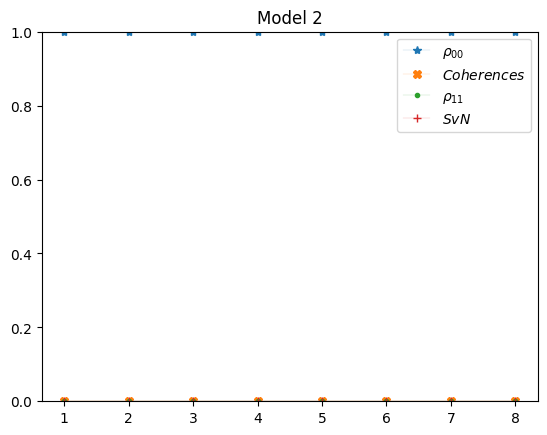

================ System 3 ===================
Ground state        : +-0.752|00000000>+-0.188|00000011>+-0.094|00000101>+-0.2|00000110>+-0.058|00001001>+-0.105|00001010>+-0.202|00001100>+-0.053|00001111>+-0.04|00010001>+-0.068|00010010>+-0.108|00010100>+-0.029|00010111>+-0.203|00011000>+-0.051|00011011>+-0.028|00011101>+-0.057|00011110>+-0.029|00100001>+-0.047|00100010>+-0.07|00100100>+-0.019|00100111>+-0.108|00101000>+-0.027|00101011>+-0.016|00101101>+-0.032|00101110>+-0.202|00110000>+-0.051|00110011>+-0.026|00110101>+-0.054|00110110>+-0.018|00111001>+-0.031|00111010>+-0.058|00111100>+-0.015|00111111>+-0.021|01000001>+-0.033|01000010>+-0.047|01000100>+-0.013|01000111>+-0.068|01001000>+-0.017|01001011>+-0.01|01001101>+-0.02|01001110>+-0.105|01010000>+-0.026|01010011>+-0.014|01010101>+-0.028|01010110>+-0.01|01011001>+-0.018|01011010>+-0.031|01011100>+-0.008|01011111>+-0.2|01100000>+-0.05|01100011>+-0.025|01100101>+-0.053|01100110>+-0.016|01101001>+-0.028|01101010>+-0.054|01101100>+-0.014

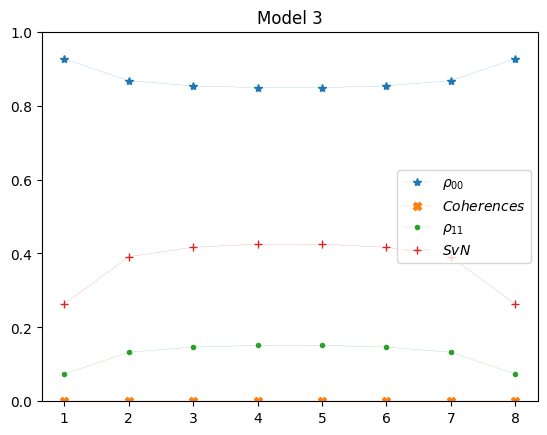

================ System 6 ===================
Ground state        : +0.375|00000000>+-0.233|00000011>+0.182|00000101>+-0.239|00000110>+0.157|00001001>+-0.203|00001010>+0.226|00001100>+-0.141|00001111>+0.202|00010001>+-0.262|00010010>+0.284|00010100>+-0.177|00010111>+0.27|00011000>+-0.168|00011011>+0.134|00011101>+-0.176|00011110>+0.037|00100001>+-0.048|00100010>+0.051|00100100>+-0.032|00100111>+0.048|00101000>+-0.03|00101011>+0.024|00101101>+-0.031|00101110>+0.062|00110000>+-0.039|00110011>+0.03|00110101>+-0.04|00110110>+0.027|00111001>+-0.035|00111010>+0.039|00111100>+-0.024|00111111>+0.005|01000001>+-0.007|01000010>+0.007|01000100>+-0.004|01000111>+0.006|01001000>+-0.004|01001011>+0.003|01001101>+-0.004|01001110>+0.008|01010000>+-0.005|01010011>+0.004|01010101>+-0.005|01010110>+0.004|01011001>+-0.005|01011010>+0.005|01011100>+-0.003|01011111>+0.013|01100000>+-0.008|01100011>+0.006|01100101>+-0.008|01100110>+0.005|01101001>+-0.007|01101010>+0.008|01101100>+-0.005|01101111>+0.007|01110

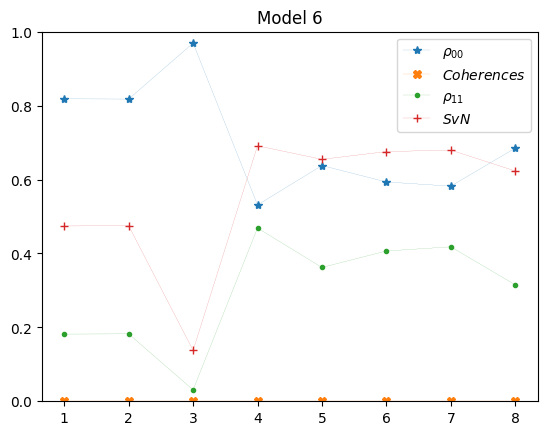

In [33]:
from scipy.linalg import eig  # Import the eig function


nspin = 8


funcs = [ Htot_2, Htot_3, Htot_6 ]
systems = [ "2", "3", "6"]


for i in range(len(funcs)):
    print(f'================ System {systems[i]} ===================')
    H = funcs[i](nspin)
    eigenvalues, eigenvectors = eig(H)

    ground_state = eigenvectors[:, 0]
    print(f'Ground state        : {diracrep(ground_state,nspin, 3)}')

    E_ground = eigenvalues[0]
    print(f'Ground state energy : {E_ground.real}')
    
    # rho = np.outer(ground_state, np.conjugate(ground_state))  
    SvNs = []
    rho_00s = []
    rho_11s = []
    coh_s = []
    for n in range(nspin):
        # print(n)
        # print(f'GS : {ground_state}')
        # print(f'N  : {n}')
        # print(f'NS : {nspin}')
        rho = densmat(ground_state, n+1, nspin)
        SvNs.append(SvN(rho))
        rho_00s.append(rho[ 0, 0])
        rho_11s.append(rho[ 1, 1])
        coh_s.append(np.abs(rho[ 1, 0]))
    #     print(np.round(rho, 3))
    # print(avdensmat(ground_state, nspin))
    print(f'Von Neuman Entropy  : {SvN(avdensmat(ground_state, nspin))}')
    D_rho = purity(rho)
    print(f'Purity              : {purity(rho)}')

    plt.plot([a+1 for a in range(len(rho_00s))], rho_00s, linestyle="-", linewidth=0.1, marker="*", label=r"$\rho_{00}$")
    plt.plot([a+1 for a in range(len(coh_s))], coh_s,     linestyle="-", linewidth=0.1, marker="X", label=r"$Coherences$")
    plt.plot([a+1 for a in range(len(rho_11s))], rho_11s, linestyle="-", linewidth=0.1, marker=".", label=r"$\rho_{11}$")
    plt.plot([a+1 for a in range(len(SvNs))], SvNs,       linestyle="-", linewidth=0.1, marker="+", label=r"$SvN$")
    plt.ylim(0,1)
    plt.title(f'Model {systems[i]}')
    plt.legend()
    plt.show()


    if False:
        import matplotlib.pyplot as plt
        populations = np.abs(ground_state)**2
        coherences = np.abs(rho - np.diag(np.diag(rho)))
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.bar(range(2**nspin), populations)
        plt.title("populations")
        plt.subplot(1, 2, 2)
        plt.imshow(coherences, cmap='gnuplot', interpolation='nearest')
        plt.title("coherences")
        plt.show()


### Results analysis

- **System 2 (Closed Ising-Z Chain)**: This system reaches a ferromagnetic ground state with all spins aligned down ($ |00000000\rangle $) and minimal energy of $-6.0$. The purity is $1.0$, and Von Neumann entropy is $0$, indicating a pure, non-entangled ground state. The closed boundary condition has no effect here due to full spin alignment.

- **System 3 (Open Ising-X Chain)**: The ground state is a superposition of many spin configurations with weights across various basis states. The ground state energy is $-4.459$, and with a Von Neumann entropy of $0.378$, the system has some degree of entanglement. The purity of $0.863$ further supports a mixed state, as expected in the open Ising-X chain, where quantum effects lead to greater configuration mixing.

- **System 6 (Randomized Open Ising-X Chain)**: (values subject to change at each run) With random Larmor frequencies and exchange integrals, the ground state energy ($0.614$) and associated superposition vary across simulations. Entropy ($0.619$) and purity ($0.573$) suggest a highly mixed state with significant entanglement. Random parameters increase the complexity, resulting in a diverse distribution of coefficients in the ground state across runs.

Systems 2 and 3 respectively represent pure and partially entangled states, while System 6, due to randomization, consistently shows a highly entangled ground state with energy and configuration variations across simulations.


# Antiferromagnetic systems

##  Ising-Z open chain

In [25]:

N = 8


def GetGroundState(H):
    eigen_vectors = []
    eigen_values = []
    phi = False # Condition for first run
    for _ in range(min(H.shape[0], eigen_to_compute)):
        eig, phi = Power_Method(H, shift, phi_prev=phi)
        eigen_vectors.append(phi) 
        eigen_values.append(eig) 
    return eigen_vectors, eigen_values


# Ferromagnietic = J=1
J = 1
H_ferro =Htot_1(N, J, omega=0)
ground_ferro_vecs, ground_ferro_vals = GetGroundState(H_ferro)
ground_ferro_vecs, ground_ferro_vals = GetGroundState(H_ferro)


# Antiferromagnietic = J=-1
J = -1
H_anti = Htot_1(N, J, omega=0)
ground_anti_vecs, ground_anti_vals = GetGroundState(H_anti)

print("======== Ferromagnetic Ground State ==========")
print(diracrep(ground_ferro_vecs[0], N, 3))
print("====== Antiferromagnetic Ground State ========")
print(diracrep(ground_anti_vecs[0], N, 3))



# # Debug for Hugo
print(csr_matrix(H_ferro))
print(H_ferro)
# print(csr_matrix(H_anti))




👍 We converged! for k:353
👍 We converged! for k:367
👍 We converged! for k:357
👍 We converged! for k:349
👍 We converged! for k:363
👍 We converged! for k:367
======== Ferromagnetic Ground State ==========
+0.013|00000000>+-1.0|11111111>
====== Antiferromagnetic Ground State ========
+0.371|01010101>+0.929|10101010>
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 256 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-1.75
  (1, 1)	-1.25
  (2, 2)	-0.75
  (3, 3)	-1.25
  (4, 4)	-0.75
  (5, 5)	-0.25
  (6, 6)	-0.75
  (7, 7)	-1.25
  (8, 8)	-0.75
  (9, 9)	-0.25
  (10, 10)	0.25
  (11, 11)	-0.25
  (12, 12)	-0.75
  (13, 13)	-0.25
  (14, 14)	-0.75
  (15, 15)	-1.25
  (16, 16)	-0.75
  (17, 17)	-0.25
  (18, 18)	0.25
  (19, 19)	-0.25
  (20, 20)	0.25
  (21, 21)	0.75
  (22, 22)	0.25
  (23, 23)	-0.25
  (24, 24)	-0.75
  :	:
  (231, 231)	-0.75
  (232, 232)	-0.25
  (233, 233)	0.25
  (234, 234)	0.75
  (235, 235)	0.25
  (236, 236)	-0.25
  (237, 237)	0.25
  (238, 238)	-0.25
  (239, 239

The ground states for the ferromagnetic and antiferromagnetic configurations are consistent in terms of the available states, even if the coefficients vary between runs:

- **Ferromagnetic Ground State**: Consists of two configurations: $ |00000000\rangle $ (all spins down) and $ |11111111\rangle $ (all spins up). These represent the two fully aligned states where all spins point in the same direction.

- **Antiferromagnetic Ground State**: Consists of two alternating configurations: $ |01010101\rangle $ and $ |10101010\rangle $. These represent the classic antiferromagnetic alignment, with neighboring spins pointing in opposite directions.

Regardless of coefficient fluctuations, the ground states are correctly represented by these basis states in each simulation run.

##  Ising-Z closed chain

In [32]:
N = 8


def GetGroundState(H):
    eigen_vectors = []
    eigen_values = []
    phi = False # Condition for first run
    for _ in range(min(H.shape[0], eigen_to_compute)):
        eig, phi = Power_Method(H, shift, phi_prev=phi)
        eigen_vectors.append(phi) 
        eigen_values.append(eig) 
    return eigen_vectors, eigen_values


# Ferromagnietic = J=1
J = 1
H_ferro =Htot_2(N, J, omega=0)
ground_ferro_vecs, ground_ferro_vals = GetGroundState(H_ferro)

# Antiferromagnietic = J=-1
J = -1
H_anti = Htot_2(N, J, omega=0)
ground_anti_vecs, ground_anti_vals = GetGroundState(H_anti)

print("======== Ferromagnetic Ground State ==========")
print(diracrep(ground_ferro_vecs[0], N, 3))
print("====== Antiferromagnetic Ground State ========")
print(diracrep(ground_anti_vecs[0], N, 3))



👍 We converged! for k:191
👍 We converged! for k:201
👍 We converged! for k:186
👍 We converged! for k:192
======== Ferromagnetic Ground State ==========
+-0.076|00000000>+-0.997|11111111>
====== Antiferromagnetic Ground State ========
+-0.704|01010101>+0.71|10101010>


- **Ferromagnetic Ground State**: The two configurations remain ∣00000000⟩∣00000000⟩ (all spins down) and ∣11111111⟩∣11111111⟩ (all spins up). The closed chain does not alter the fully aligned state, so all spins remain parallel across the boundaries.

- **Antiferromagnetic Ground State**: Here, the ground state configuration shows a preference for ∣01010101⟩∣01010101⟩, with minimal presence of ∣10101010⟩∣10101010⟩. In a closed chain, periodic boundary conditions mean that the spin alignment must be consistent across the boundary. As a result, configurations like ∣01010101⟩∣01010101⟩ (an even number of sites with perfect alternation) are more stable, while ∣10101010⟩∣10101010⟩ is effectively suppressed.

In an Ising-Z closed chain with an odd number of spins, the antiferromagnetic ground state allows for cyclic permutations of two types of configurations:

1. **Configurations with "00" in the loop**: Due to the odd spin count, a perfect alternation (like $ |010101 \dots \rangle $) is not possible without ending in a pair of identical spins, creating a configuration where two neighboring spins are down.

2. **Configurations with "11" in the loop**: Similarly, cyclic permutations can also result in configurations where two neighboring spins are up.

These cyclic permutations accommodate the boundary condition and the odd spin count, resulting in a set of degenerate states that maintain the antiferromagnetic ordering as closely as possible.

### Open and Closed comparison

In an Ising-Z chain, open and closed systems differ in how boundary conditions affect the ground state configurations. An open chain has free ends, allowing perfect antiferromagnetic ordering for even and odd numbers of spins without additional constraints. In a closed chain, however, the boundary wraps around, creating a “border” issue for an odd number of spins: it’s impossible to perfectly alternate spins without introducing a pair of identical spins at the boundary. This constraint leads to degenerate ground states with cyclic permutations of configurations that minimize the boundary mismatch, especially evident in the antiferromagnetic phase.

## Antiferromagnetic spin triangle frustration

<!-- ### Frustration in Different Dimensions

1. **One-Dimensional (1D) Systems:**
   - **Linear Chains:** In a simple 1D antiferromagnetic chain, spins can interact with their nearest neighbors, and it is typically possible to arrange them in an alternating up-down pattern (e.g., ↑↓↑↓), satisfying the antiferromagnetic condition without frustration. Hence, a 1D chain of spins is generally not frustrated.
   - **Frustration in Higher-Order Interactions:** However, frustration can arise in 1D systems with more complex interactions. For instance:
     - If a 1D chain has longer-range interactions (e.g., next-nearest neighbors) or if it includes competing interactions (such as an antiferromagnetic interaction combined with ferromagnetic interactions), frustration can occur.
     - An example would be a chain where every third spin interacts antiferromagnetically, making it impossible to satisfy all interactions simultaneously.

2. **Two-Dimensional (2D) and Higher Systems:**
   - **Geometric Frustration:** In 2D and higher-dimensional systems, frustration often arises due to the geometry of the lattice (e.g., triangular, kagome, or pyrochlore lattices). In these cases, the arrangement of spins leads to competing interactions that cannot all be satisfied simultaneously, resulting in frustration.
   - **Exotic Phases:** Frustrated systems in 2D can lead to interesting physical phenomena, such as spin liquids or exotic ordering, because of the large number of degenerate ground states and the inability to reach a simple ordered state.


### Example of Frustration in 1D
To illustrate frustration in a 1D system, consider a 1D chain of spins with the following configuration:

- **Spin Interactions:** Suppose the spins interact as follows: \( J_1 \) (nearest neighbors) and \( J_2 \) (next-nearest neighbors), with \( J_1 < 0 \) (antiferromagnetic) and \( J_2 > 0 \) (ferromagnetic).
- In this case, the competing interactions between the nearest and next-nearest neighbors can lead to frustration, resulting in a complex ground state that may not be simply alternating.

Overall, while frustration is more commonly associated with 2D and 3D systems due to their geometric properties, it can indeed exist in 1D systems under certain conditions. -->


### Schema

Given the antiferromagnetic nature of the system, neighboring spins must align in opposite directions during interactions.

#### 2D case 

Say we have spin up : ⊙ and down : ◯

```
 ◯         ⊙ 
⊙ ◯   or  ◯ ⊙

```

In the 2D configuration above, there are 2 valid configurations. However in both of them, the top spin will never be able to minimize its interaction with the 2 others at the same time. Thus, the system is frustrated, since it cannot find a configuration where all interacting pairs' energies are minimized.

#### 1D case

`↑↓`*`↑`*`↓↑` <br>
`___^ Spin of interest`

If we consider only neighbor interactions, the system above is not frustrated, however, if neighbors+1 interactions are considered, it is. The spin can minimize its energy with its 2 nearest neighbors, but is unable to do so with the next one. Thus this system is frustrated, since it cannot find a configuration where all interacting pairs energies are minimized.


# Dynamics of lattice spin systems

## Studied models

We decide to redefine the previous quantities. Integrating omega inside $\sigma$ in the previous revealed to be a foulish mistake in the end.

In [39]:
# Pauli matrices
Sigma_3 = {
    'x': 0.5 * np.array([[0, 1], [1, 0]]),
    'y': 0.5 * np.array([[0, -1j], [1j, 0]]),
    'z': 0.5 * np.array([[1, 0], [0, -1]])
}

Sigma_x = 1 * np.array([[-1, 0],[0,0]])

### [1] Heisenberg-XXX open chain (homogeneous coupling)

In [40]:
def Htot_3_1(n, J=0.1):

    H_free = np.zeros((2**n, 2**n))
    H_interaction = np.zeros((2**n, 2**n))

    for i in range(1, n+1):
        H_free += opchain(Sigma_x, i, n)

    for i in range(n-1):
        H_interaction += np.real(-J * opchain2(Sigma_3["x"], i+1, Sigma_3["x"], i+2, n))
        H_interaction += np.real(-J * opchain2(Sigma_3["y"], i+1, Sigma_3["y"], i+2, n))
        H_interaction += np.real(-J * opchain2(Sigma_3["z"], i+1, Sigma_3["z"], i+2, n))
    
    Htot = H_free + H_interaction
    return Htot
print(csr_matrix(Htot_3_1(7)))

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 512 stored elements and shape (128, 128)>
  Coords	Values
  (0, 0)	-7.15
  (1, 1)	-6.1
  (1, 2)	-0.05
  (2, 1)	-0.05
  (2, 2)	-6.05
  (2, 4)	-0.05
  (3, 3)	-5.1
  (3, 5)	-0.05
  (4, 2)	-0.05
  (4, 4)	-6.05
  (4, 8)	-0.05
  (5, 3)	-0.05
  (5, 5)	-5.0
  (5, 6)	-0.05
  (5, 9)	-0.05
  (6, 5)	-0.05
  (6, 6)	-5.05
  (6, 10)	-0.05
  (7, 7)	-4.1
  (7, 11)	-0.05
  (8, 4)	-0.05
  (8, 8)	-6.05
  (8, 16)	-0.05
  (9, 5)	-0.05
  (9, 9)	-5.0
  :	:
  (118, 118)	-2.0
  (118, 122)	-0.05
  (119, 111)	-0.05
  (119, 119)	-1.05
  (119, 123)	-0.05
  (120, 116)	-0.05
  (120, 120)	-3.1
  (121, 117)	-0.05
  (121, 121)	-2.05
  (121, 122)	-0.05
  (122, 118)	-0.05
  (122, 121)	-0.05
  (122, 122)	-2.0
  (122, 124)	-0.05
  (123, 119)	-0.05
  (123, 123)	-1.05
  (123, 125)	-0.05
  (124, 122)	-0.05
  (124, 124)	-2.1
  (125, 123)	-0.05
  (125, 125)	-1.05
  (125, 126)	-0.05
  (126, 125)	-0.05
  (126, 126)	-1.1
  (127, 127)	-0.15


### [2] Heisenberg-XXX closed chain

In [41]:
def Htot_3_2(n, J=0.1):

    # Free Hamiltonian (same as before)
    H_free = np.zeros((2**n, 2**n))
    H_interaction = np.zeros((2**n, 2**n))

    for i in range(1, n+1):
        H_free += opchain(Sigma_x, i, n)

    for i in range(n-1):
        # Add interactions for X, Y, and Z directions and cast to real if necessary
        H_interaction += np.real(-J * opchain2(Sigma_3["x"], i+1, Sigma_3["x"], i+2, n))
        H_interaction += np.real(-J * opchain2(Sigma_3["y"], i+1, Sigma_3["y"], i+2, n))
        H_interaction += np.real(-J * opchain2(Sigma_3["z"], i+1, Sigma_3["z"], i+2, n))
        
    H_interaction += np.real(-J * opchain2(Sigma_3["x"], 1, Sigma_3["x"], n, n))
    H_interaction += np.real(-J * opchain2(Sigma_3["y"], 1, Sigma_3["y"], n, n))
    H_interaction += np.real(-J * opchain2(Sigma_3["z"], 1, Sigma_3["z"], n, n))
    
    Htot = H_free + H_interaction
    return Htot

print(csr_matrix(Htot_3_2(7)))

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 576 stored elements and shape (128, 128)>
  Coords	Values
  (0, 0)	-7.175
  (1, 1)	-6.075
  (1, 2)	-0.05
  (1, 64)	-0.05
  (2, 1)	-0.05
  (2, 2)	-6.075
  (2, 4)	-0.05
  (3, 3)	-5.075
  (3, 5)	-0.05
  (3, 66)	-0.05
  (4, 2)	-0.05
  (4, 4)	-6.075
  (4, 8)	-0.05
  (5, 3)	-0.05
  (5, 5)	-4.975
  (5, 6)	-0.05
  (5, 9)	-0.05
  (5, 68)	-0.05
  (6, 5)	-0.05
  (6, 6)	-5.075
  (6, 10)	-0.05
  (7, 7)	-4.075
  (7, 11)	-0.05
  (7, 70)	-0.05
  (8, 4)	-0.05
  :	:
  (119, 123)	-0.05
  (120, 57)	-0.05
  (120, 116)	-0.05
  (120, 120)	-3.075
  (121, 117)	-0.05
  (121, 121)	-2.075
  (121, 122)	-0.05
  (122, 59)	-0.05
  (122, 118)	-0.05
  (122, 121)	-0.05
  (122, 122)	-1.975
  (122, 124)	-0.05
  (123, 119)	-0.05
  (123, 123)	-1.075
  (123, 125)	-0.05
  (124, 61)	-0.05
  (124, 122)	-0.05
  (124, 124)	-2.075
  (125, 123)	-0.05
  (125, 125)	-1.075
  (125, 126)	-0.05
  (126, 63)	-0.05
  (126, 125)	-0.05
  (126, 126)	-1.075
  (127, 127)	-0.175


### [3] Inhomogenous Heisenberg-XXX open chain

In [46]:

def Htot_3_3(n):
    H_free = np.zeros((2**n, 2**n))
    H_interaction = np.zeros((2**n, 2**n))

    for i in range(1, n + 1):
        H_free += opchain(Sigma_x, i, n)

    for i in range(n - 1):
        Ji = 0.5 / (i+1)  # Adjust for inhomogeneous coupling
        H_interaction += np.real(-Ji * opchain2(Sigma_3["x"], i + 1, Sigma_3["x"], i + 2, n))
        H_interaction += np.real(-Ji * opchain2(Sigma_3["y"], i + 1, Sigma_3["y"], i + 2, n))
        H_interaction += np.real(-Ji * opchain2(Sigma_3["z"], i + 1, Sigma_3["z"], i + 2, n))

    Htot = H_free + H_interaction
    return Htot
print(csr_matrix(Htot_3_3(7)))


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 512 stored elements and shape (128, 128)>
  Coords	Values
  (0, 0)	-7.30625
  (1, 1)	-6.264583333333333
  (1, 2)	-0.041666666666666664
  (2, 1)	-0.041666666666666664
  (2, 2)	-6.214583333333334
  (2, 4)	-0.05
  (3, 3)	-5.25625
  (3, 5)	-0.05
  (4, 2)	-0.05
  (4, 4)	-6.19375
  (4, 8)	-0.0625
  (5, 3)	-0.05
  (5, 5)	-5.152083333333334
  (5, 6)	-0.041666666666666664
  (5, 9)	-0.0625
  (6, 5)	-0.041666666666666664
  (6, 6)	-5.202083333333333
  (6, 10)	-0.0625
  (7, 7)	-4.24375
  (7, 11)	-0.0625
  (8, 4)	-0.0625
  (8, 8)	-6.160416666666666
  (8, 16)	-0.08333333333333333
  (9, 5)	-0.0625
  (9, 9)	-5.11875
  :	:
  (118, 118)	-2.11875
  (118, 122)	-0.0625
  (119, 111)	-0.08333333333333333
  (119, 119)	-1.1604166666666667
  (119, 123)	-0.0625
  (120, 116)	-0.0625
  (120, 120)	-3.24375
  (121, 117)	-0.0625
  (121, 121)	-2.2020833333333334
  (121, 122)	-0.041666666666666664
  (122, 118)	-0.0625
  (122, 121)	-0.041666666666666664
  (122

## Spectral Integrator

In [49]:
from scipy.linalg import expm

def Dyn(H, t, psi0):
    U = expm(-1j * H * t)
    psi_t = U @ psi0
    return psi_t

/tmp/ipykernel_1104445/1876986340.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  pop[i, k] = rho_k[2**k, 2**k]


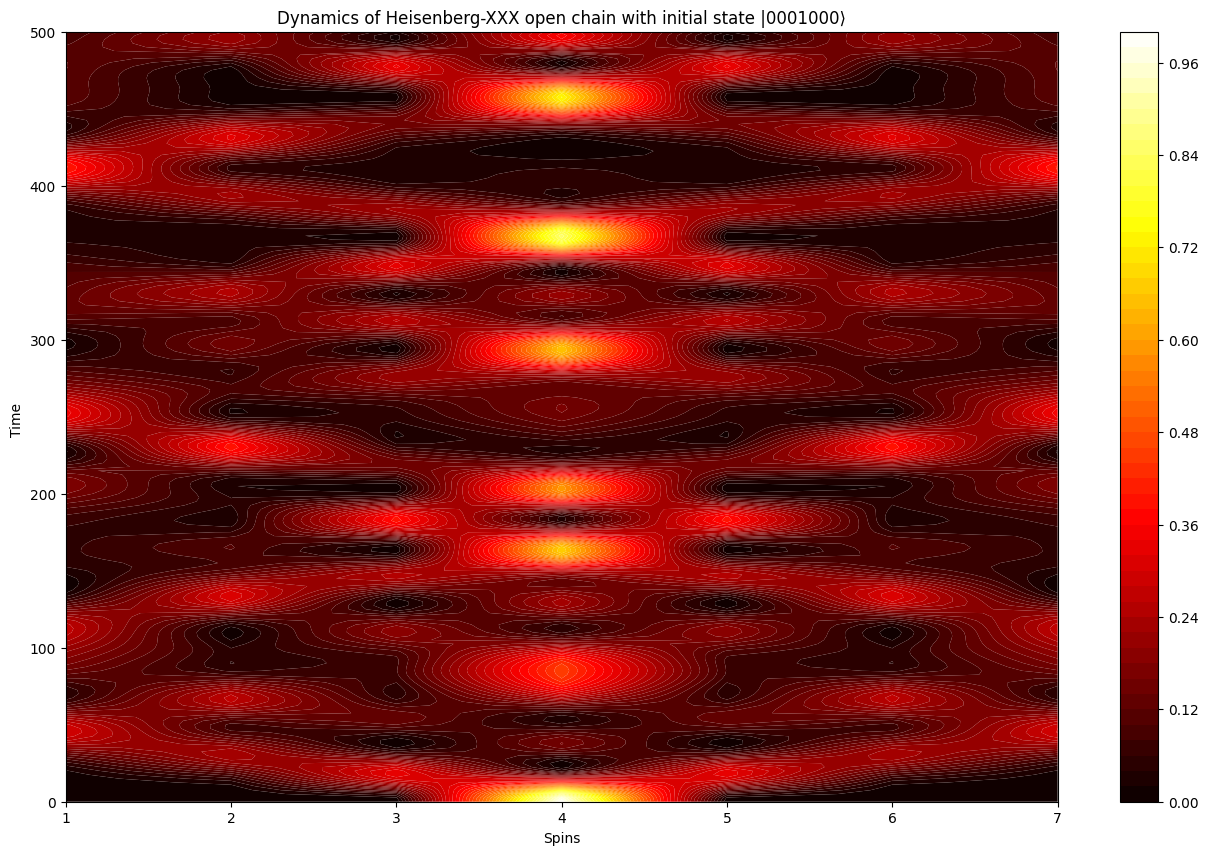

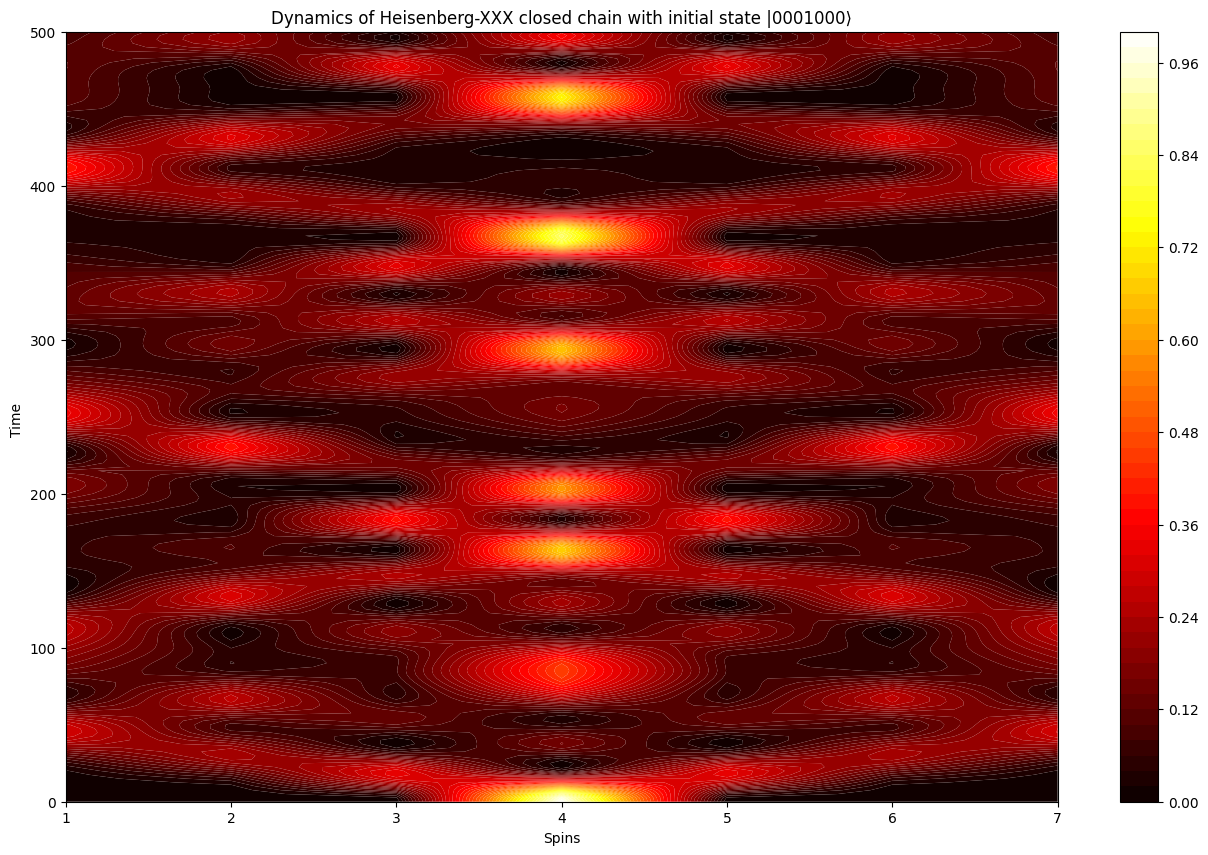

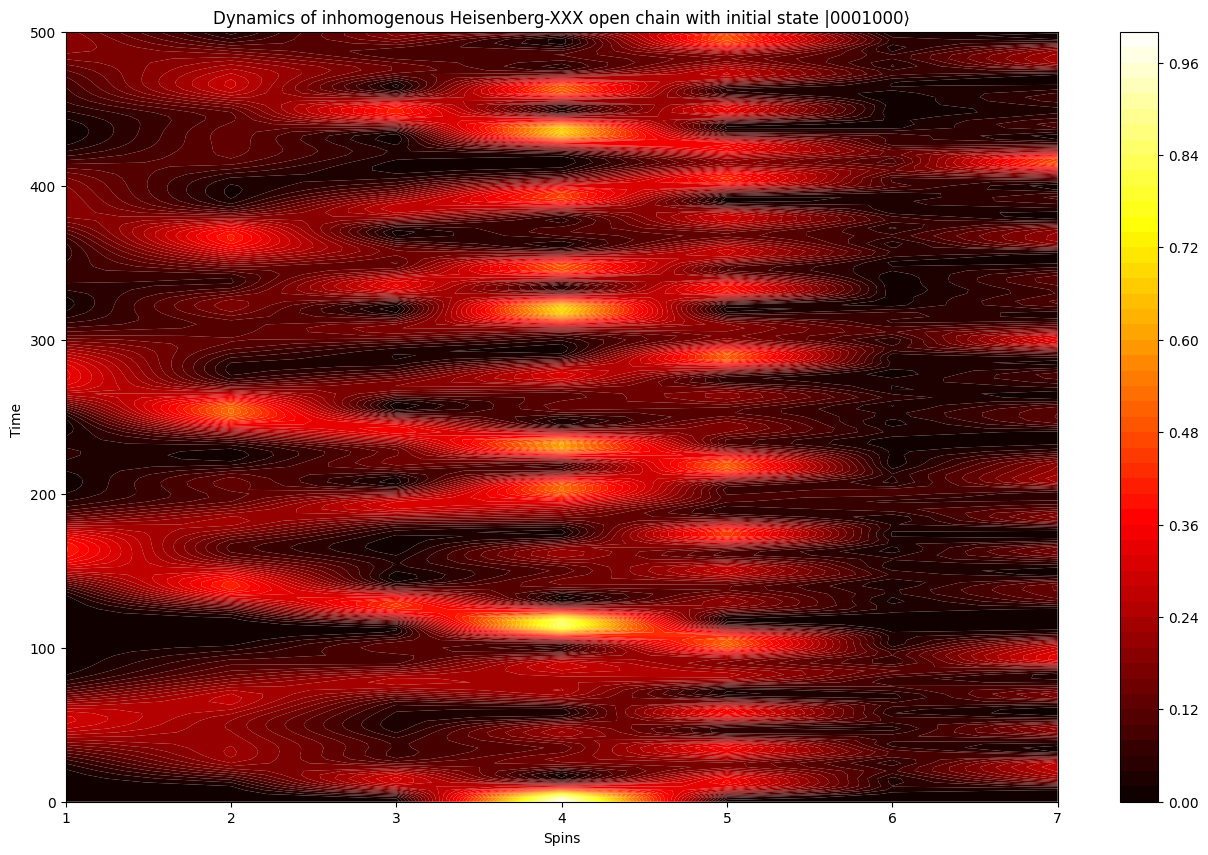

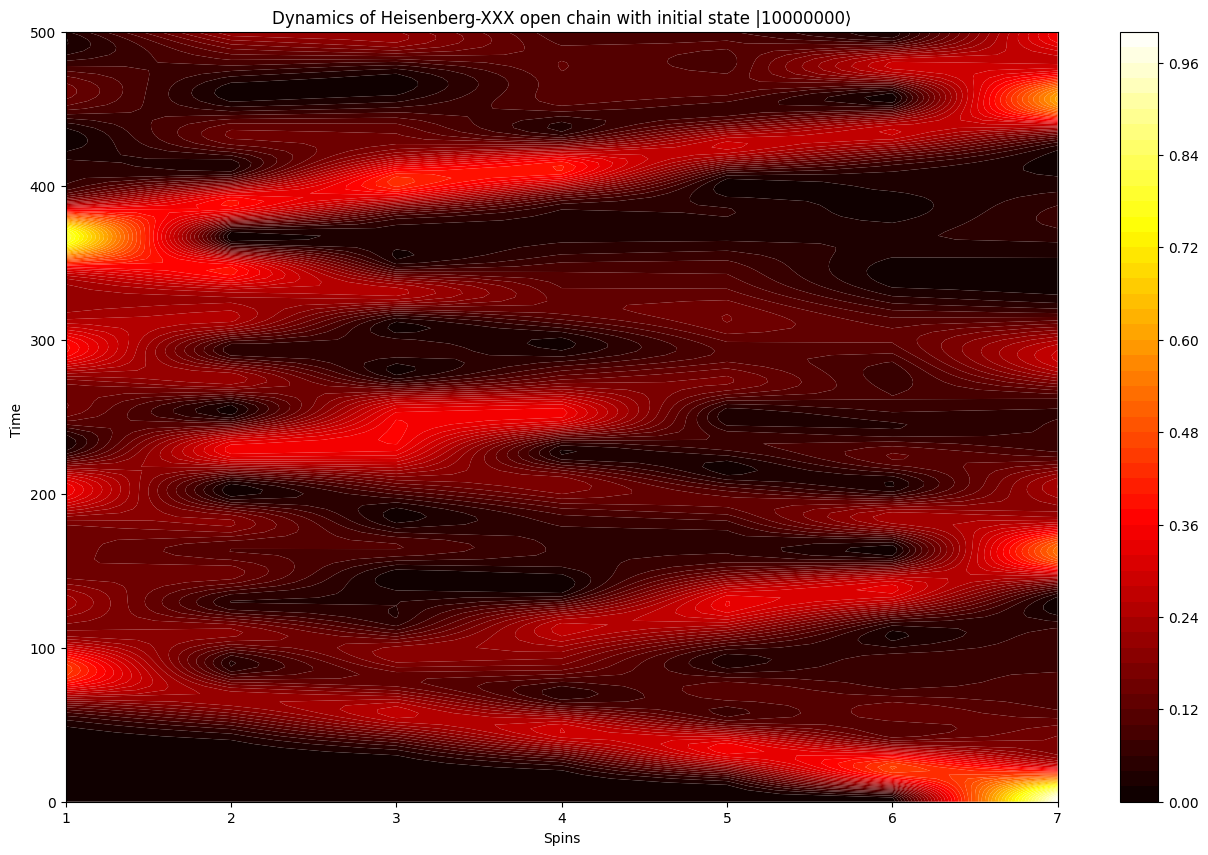

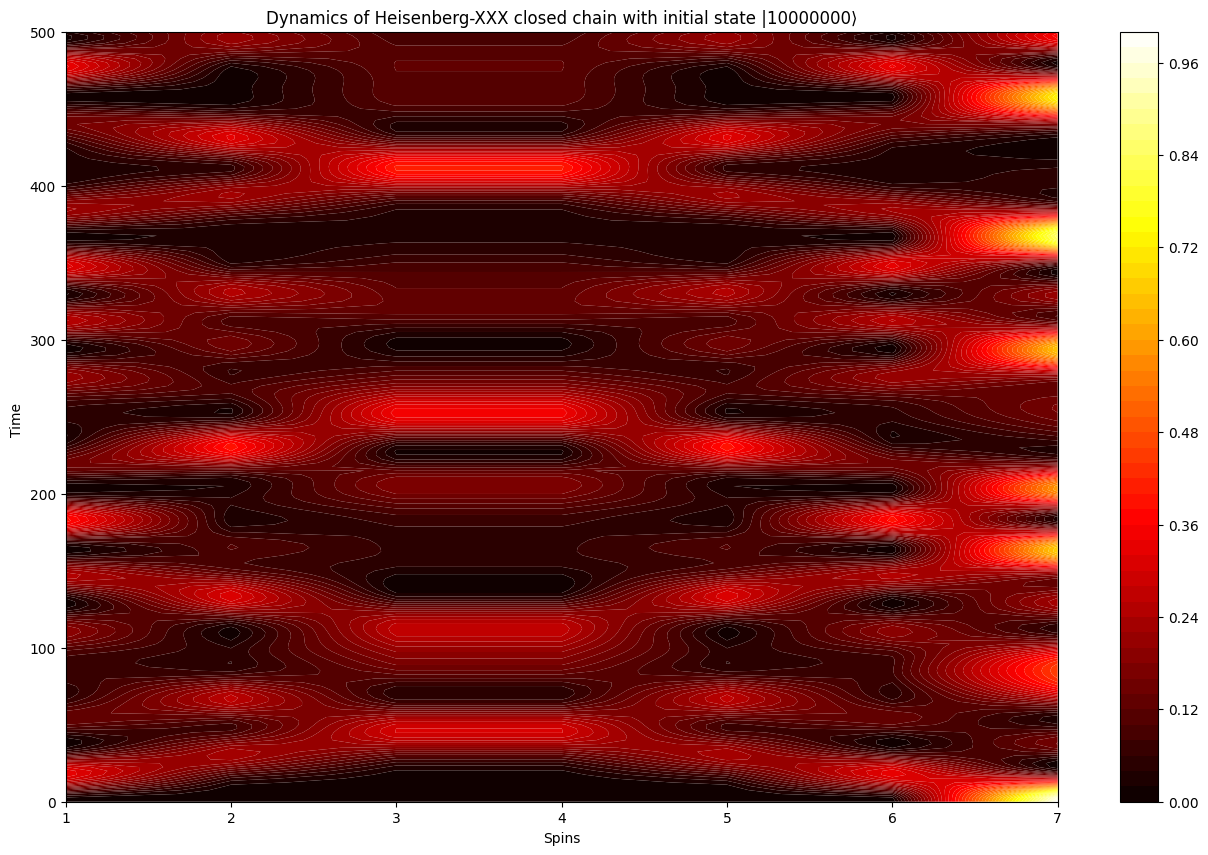

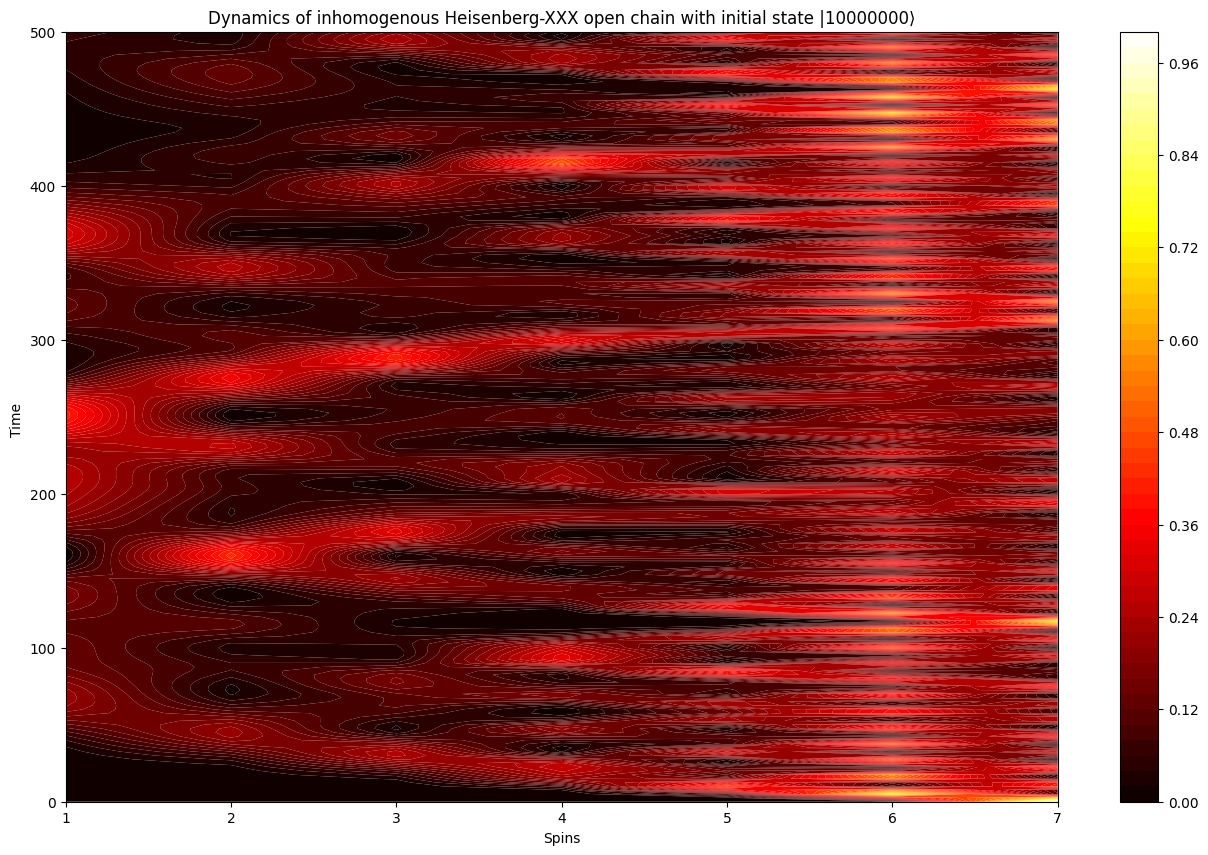

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def carpet(model, T, nspin, psi0, i_state):
    """Based on TD subject"""

    N_time = 200
    dt = T / N_time
    pop = np.zeros((N_time + 1, nspin))  # populations

    for i in range(N_time + 1):
        t = i * dt
        psi_t = Dyn(model.H, t, psi0)
        
        #reduced density matrix for the state
        rho_k = np.outer(psi_t, np.conj(psi_t))  # Full density matrix
        
        # populations 
        for k in range(nspin):
            pop[i, k] = rho_k[2**k, 2**k]  

    # Plotting the results
    plt.figure(figsize=(16, 10))
    plt.contourf(range(1, nspin + 1), [i * dt for i in range(N_time + 1)], pop, levels=[i * 0.02 for i in range(51)], cmap='hot', antialiased=True)
    plt.xlabel("Spins")
    plt.ylabel("Time ")
    plt.colorbar()
    plt.title(f'Dynamics of {model.name} with initial state {i_state}')
    
    # Corrected file saving
    plt.savefig(f'graphpop_{model.name}.png')
    plt.show()

# Initialize population lists for each model
models = ['Heisenberg-XXX open chain', 'Heisenberg-XXX closed chain', 'inhomogenous Heisenberg-XXX open chain']
nspin = 7

# Initial states for the spins
psi0_4 = np.zeros(2**nspin, dtype=complex)
psi0_4[8] = 1  # 8 c=> position 0001000

psi0_1 = np.zeros(2**nspin, dtype=complex)
psi0_1[64] = 1  # 64 => position 1000000


# Loop through each model and perform the dynamics
psi0 = psi0_4
initial_state = "|0001000⟩"
for model_name in models:
    match model_name:
        case 'Heisenberg-XXX open chain':
            H = Htot_3_1(nspin)
        case 'Heisenberg-XXX closed chain':
            H = Htot_3_2(nspin)
        case 'inhomogenous Heisenberg-XXX open chain':
            H = Htot_3_3(nspin)

    model = type('Model', (object,), {'H': H, 'name': model_name})  # Creating a simple model object

    # Call the plot_dynamics function
    carpet(model, 500, nspin, psi0, initial_state)

psi0 = psi0_1
initial_state = "|10000000⟩"
for model_name in models:
    match model_name:
        case 'Heisenberg-XXX open chain':
            H = Htot_3_1(nspin)
        case 'Heisenberg-XXX closed chain':
            H = Htot_3_2(nspin)
        case 'inhomogenous Heisenberg-XXX open chain':
            H = Htot_3_3(nspin)

    model = type('Model', (object,), {'H': H, 'name': model_name})()  # Creating a simple model object

    carpet(model, 500, nspin, psi0, initial_state)

## Varying $\omega$ and $J$ for **system 1**

In [ ]:
def Htot_3_1_variable(n, J=0.1, omega=1):
    H_free = np.zeros((2**n, 2**n))
    H_interaction = np.zeros((2**n, 2**n))

    for i in range(1, n+1):
        H_free += opchain(omega*Sigma_x, i, n)

    for i in range(n-1):
        H_interaction += np.real(-J * opchain2(Sigma_3["x"], i+1, Sigma_3["x"], i+2, n))
        H_interaction += np.real(-J * opchain2(Sigma_3["y"], i+1, Sigma_3["y"], i+2, n))
        H_interaction += np.real(-J * opchain2(Sigma_3["z"], i+1, Sigma_3["z"], i+2, n))
    
    Htot = H_free + H_interaction
    return Htot
print(csr_matrix(Htot_3_1(7)))



omegas = np.linspace(0,2,5)
Js = np.linspace(0,1,5)
for omega in omegas:
    for J in Js:
        Htot_3_1_variable(nspin, J, omega)
        model = type('Model', (object,), {'H': H, 'name': model_name})
        carpet(model)